## Bibliotecas

In [1]:
import sys
sys.path.append('../')

In [2]:
## Spark SQL
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t

# Spark ML
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Imputer, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator

In [3]:
import pickle

In [4]:
spark = (
    SparkSession
    .builder
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .getOrCreate()
)

In [5]:
import pandas as pd
pd.set_option("display.max_columns", None)

## Dados

In [6]:
# df_basics = (
#     spark.read.parquet('../data/imdb/title_basics')
#     .withColumn('n_genres', f.size('genres'))
#     .withColumn('numVotes', f.col('numVotes').cast('int'))
#     .withColumn('averageRating', f.col('averageRating').cast('int'))
#     .withColumn('genres', f.explode(f.col('genres')))
#     .withColumn('genres', f.regexp_replace(f.lower(f.col('genres')), '-', '_'))
#     .withColumn('data_ano', f.to_date(f.col('startYear').cast('string'), 'yyyy'))
#     .withColumn('idade_filme_dias', f.datediff(f.current_date(), f.col('data_ano')))
#     .withColumn('idade_anos', f.floor(f.col('idade_filme_dias') / 365))
# )

In [ ]:
# possible_genres = [c['genres'] for c in df_basics.select('genres').distinct().collect()]

In [ ]:
# pickle.dump(possible_genres, open('../data/posiible_genres.pkl', "wb"))

In [6]:
possible_genres = pickle.load(open('../data/posiible_genres.pkl', "rb"))

In [ ]:
# df_model = (
#     df_basics
#     .groupby([c for c in df_basics.columns if c != "genres"])
#     .pivot('genres', possible_genres)
#     .count()
#     .fillna(0, subset=possible_genres)
# )
# df_model.write.parquet('../data/imdb/imdb_ml', mode='overwrite')

In [8]:
df = spark.read.parquet('../data/imdb/imdb_ml')

In [9]:
df.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy
0,tt1865160,tvEpisode,Pool Charks,Pool Charks,0,2011,NaN,44.0,7,7,2,2011-01-01,3904,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,tt6253410,tvEpisode,Ash Ketchum vs Charles Darwin,Ash Ketchum vs Charles Darwin,0,2016,NaN,2.0,6,65,3,2016-01-01,2078,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2,tt11769614,tvEpisode,Dragon's Children,Dragon's Children,0,2011,NaN,130.0,8,7,3,2011-01-01,3904,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
3,tt0982624,tvEpisode,Boryaku,Boryaku,0,2004,NaN,NaN,6,5,3,2004-01-01,6461,17,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,tt13102170,tvEpisode,Wrong Turn,Wrong Turn,0,2020,NaN,43.0,7,12,1,2020-01-01,617,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Supervised Learning: Regressão

### Data Split

In [10]:
df_train, df_test = df.randomSplit([0.7, 0.3], 13)

In [11]:
df_train.count()

812013

In [12]:
df_test.count()

347654

### Preprocessamento

#### Variáveis Categóricas

In [13]:
cat_cols = ['titleType', 'isAdult'] + possible_genres

In [14]:
indexed_cols = [c + '_indexed' for c in cat_cols]
ohe_cols = [c + '_ohe' for c in cat_cols]
# Cria as variáveis categóricas
indexer = StringIndexer(
    inputCols = cat_cols,
    outputCols=indexed_cols,
    handleInvalid = 'keep'
)
# Realiza o One Hot Encoding
ohe = OneHotEncoder(
    inputCols = indexed_cols,
    outputCols=ohe_cols
)

In [15]:
indexer_fit = indexer.fit(df_train)

In [16]:
df_train = indexer_fit.transform(df_train)

In [17]:
ohe_fit = ohe.fit(df_train)

In [18]:
df_train = ohe_fit.transform(df_train)

In [19]:
df_train.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
1,tt0000042,short,Bateau-mouche sur la Seine,Bateau-mouche sur la Seine,0,1896,NaN,NaN,4,34,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
2,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
3,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequeno,0,1896,NaN,NaN,3,20,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","

#### Variáveis Numéricas

* **MinMaxScaler:** trunca as variáveis entre 0 e 1, usando o valor mínimo e máximo observado
* **StandardScaler:** padroniza, tirando a média e dividindo pelo desvio padrão
* **RobustScaler:** normalização robusta em relação a outliers, usa o primeiro e terceiro quartis

In [20]:
num_cols = ['idade_anos', 'numVotes', 'n_genres', 'runtimeMinutes']

In [21]:
for c in num_cols:
    print(c, ': ', df_train.filter(f'{c} is null').count())

idade_anos :  112
numVotes :  0
n_genres :  0
runtimeMinutes :  217059


In [22]:
imputed_cols = [c + '_imputed' for c in num_cols]
imputer = Imputer(
    inputCols = num_cols,
    outputCols=imputed_cols
)

In [23]:
assembler = VectorAssembler(
    inputCols=imputed_cols,
    outputCol='num_vec',
)

In [24]:
scaler = StandardScaler(
    inputCol = 'num_vec',
    outputCol = 'num_vec_scaled'
)

In [25]:
imputer_fit = imputer.fit(df_train)

In [26]:
df_train = imputer_fit.transform(df_train)

In [27]:
df_train = assembler.transform(df_train)

In [28]:
scaler_fit = scaler.fit(df_train)

In [29]:
df_train = scaler_fit.transform(df_train)

In [30]:
df_train.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.881172316555216, 0.0014096962256050197, 1.1..."
1,tt0000042,short,Bateau-mouche sur la Seine,Bateau-mouche sur la Seine,0,1896,NaN,NaN,4,34,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,34,2,54,"[125.0, 34.0, 2.0, 54.0]","[5.881172316555216, 0.0019970696529404445, 2.3..."
2,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.881172316555216, 0.0018208576247398171, 2.3..."
3,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequeno,0,1896,NaN,NaN,3,20,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Assemble Features

In [31]:
features = ['num_vec_scaled'] + ohe_cols

final_assembler = VectorAssembler(
    inputCols=features,
    outputCol='features',
)

In [32]:
df_train = final_assembler.transform(df_train)

In [33]:
df_train.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.881172316555216, 0.0014096962256050197, 1.1...","(5.881172316555216, 0.0014096962256050197, 1.1..."
1,tt0000042,short,Bateau-mouche sur la Seine,Bateau-mouche sur la Seine,0,1896,NaN,NaN,4,34,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,34,2,54,"[125.0, 34.0, 2.0, 54.0]","[5.881172316555216, 0.0019970696529404445, 2.3...","(5.881172316555216, 0.0019970696529404445, 2.3..."
2,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.881172316555216, 0.0018208576247398171, 2.3...","(5.881172316555216, 0.0018208576247398171, 2.3..."
3,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequeno,0,1896,NaN,NaN,3,20,1,1896-01-01,4

### Ajuste do Modelo

In [34]:
lr = LinearRegression(labelCol = 'averageRating', standardization=False)

In [35]:
lr_fit = lr.fit(df_train)

In [36]:
lr_fit.transform(df_train).limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features,prediction
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.881172316555216, 0.0014096962256050197, 1.1...","(5.881172316555216, 0.0014096962256050197, 1.1...",5.636906
1,tt0000042,short,Bateau-mouche sur la Seine,Bateau-mouche sur la Seine,0,1896,NaN,NaN,4,34,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,34,2,54,"[125.0, 34.0, 2.0, 54.0]","[5.881172316555216, 0.0019970696529404445, 2.3...","(5.881172316555216, 0.0019970696529404445, 2.3...",6.110738
2,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.881172316555216, 0.0018208576247398171, 2.3...","(5.881172316555216, 0.0018208576247398171, 2.3...",6.110728
3,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequ

In [37]:
lr_fit.summary.r2

0.18218764172895419

In [38]:
lr_fit.summary.meanAbsoluteError

0.9717304854906156

In [39]:
lr_fit.summary.meanSquaredError

1.650771432415923

In [40]:
lr_fit.summary.rootMeanSquaredError

1.2848235024375616

### Predições

In [41]:
lr_fit.transform(df_test)

IllegalArgumentException: features does not exist. Available: tconst, titleType, primaryTitle, originalTitle, isAdult, startYear, endYear, runtimeMinutes, averageRating, numVotes, n_genres, data_ano, idade_filme_dias, idade_anos, biography, crime, game_show, fantasy, documentary, sci_fi, news, action, animation, mystery, sport, family, horror, adult, history, reality_tv, music, musical, adventure, talk_show, drama, film_noir, western, war, short, romance, thriller, comedy

In [42]:
df_test = final_assembler.transform(scaler_fit.transform(assembler.transform(imputer_fit.transform(ohe_fit.transform(indexer_fit.transform(df_test))))))

In [43]:
df_test.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features
0,tt0000040,short,Barque sortant du port de Trouville,Barque sortant du port de Trouville,0,1896,NaN,NaN,4,58,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,58,2,54,"[125.0, 58.0, 2.0, 54.0]","[5.881172316555216, 0.003406765878545464, 2.39...","(5.881172316555216, 0.003406765878545464, 2.39..."
1,tt0000069,short,Post No Bills,Defense d'afficher,0,1896,NaN,1.0,4,410,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,410,1,1,"[125.0, 410.0, 1.0, 1.0]","[5.881172316555216, 0.02408231052075242, 1.198...","(5.881172316555216, 0.02408231052075242, 1.198..."
2,tt0000132,short,Card Party,Une partie de cartes,0,1896,NaN,1.0,5,976,2,1896-01-01,45907,125,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,976,2,1,"[125.0, 976.0, 2.0, 1.0]","[5.881172316555216, 0.057327646507937466, 2.39...","(5.881172316555216, 0.057327646507937466, 2.39..."
3,tt0000181,short,Cinderella,Cinderella,0,1898,NaN,NaN,6,55,2,1898-01-01,45176,123,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [44]:
df_test = lr_fit.transform(df_test)

### Avaliação do Modelo

In [45]:
evaluator = RegressionEvaluator(labelCol='averageRating', metricName='rmse')

In [46]:
evaluator.evaluate(df_test)

1.2844101728132467

### Jeito mais fácil: usando Pipelines

In [47]:
df_train, df_test = df.randomSplit([0.7, 0.3], 13)

In [48]:
pipeline = Pipeline(stages=[indexer, ohe, imputer, assembler, scaler, final_assembler, lr])

In [49]:
pipeline

Pipeline_edb33336f0d6

In [50]:
pipeline_fit = pipeline.fit(df_train)

In [51]:
pipeline_fit.transform(df_train).limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,talk_show_indexed,isAdult_indexed,music_indexed,thriller_indexed,mystery_indexed,short_indexed,fantasy_indexed,war_indexed,titleType_indexed,adventure_indexed,documentary_indexed,reality_tv_indexed,family_indexed,adult_indexed,action_indexed,horror_indexed,sci_fi_indexed,musical_indexed,sport_indexed,history_indexed,animation_indexed,game_show_indexed,news_indexed,crime_indexed,comedy_indexed,biography_indexed,western_indexed,romance_indexed,film_noir_indexed,drama_indexed,animation_ohe,history_ohe,drama_ohe,action_ohe,horror_ohe,fantasy_ohe,romance_ohe,musical_ohe,film_noir_ohe,western_ohe,talk_show_ohe,biography_ohe,adventure_ohe,short_ohe,sci_fi_ohe,music_ohe,isAdult_ohe,reality_tv_ohe,titleType_ohe,mystery_ohe,game_show_ohe,war_ohe,documentary_ohe,adult_ohe,crime_ohe,thriller_ohe,family_ohe,sport_ohe,comedy_ohe,news_ohe,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features,prediction
0,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,3,24,1,1896-01-01,45907,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,24,1,54,"[125.0, 24.0, 1.0, 54.0]","[5.881172316555216, 0.0014096962256050197, 1.1...","(5.881172316555216, 0.0014096962256050197, 1.1...",5.636906
1,tt0000042,short,Bateau-mouche sur la Seine,Bateau-mouche sur la Seine,0,1896,NaN,NaN,4,34,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,34,2,54,"[125.0, 34.0, 2.0, 54.0]","[5.881172316555216, 0.0019970696529404445, 2.3...","(5.881172316555216, 0.0019970696529404445, 2.3...",6.110738
2,tt0000046,short,Bois de Boulogne,Bois de Boulogne,0,1896,NaN,NaN,4,31,2,1896-01-01,45907,125,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",125,31,2,54,"[125.0, 31.0, 2.0, 54.0]","[5.881172316555216, 0.0018208576247398171, 2.3...","(5.881172316555216, 0.0018208576247398171, 2.3...",6.110728
3,tt0000056,short,Uma Corrida de Touros no Campo Pequeno,Uma Corrida de Touros no Campo Pequ

In [52]:
df_test = pipeline_fit.transform(df_test)

In [53]:
evaluator.evaluate(df_test)

1.2844101728132467

## Unsupervised Learning: Clustering

### Ajuste

In [54]:
kmeans = KMeans(k=5, seed=13)

In [55]:
features = ['num_vec_scaled']

final_assembler = VectorAssembler(
    inputCols=features,
    outputCol='features',
)

In [56]:
pipeline = Pipeline(stages=[imputer, assembler, scaler, final_assembler, kmeans])

In [57]:
pipeline_fit = pipeline.fit(df)

In [58]:
df_cluster = pipeline_fit.transform(df)

In [59]:
df_cluster.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,n_genres,data_ano,idade_filme_dias,idade_anos,biography,crime,game_show,fantasy,documentary,sci_fi,news,action,animation,mystery,sport,family,horror,adult,history,reality_tv,music,musical,adventure,talk_show,drama,film_noir,western,war,short,romance,thriller,comedy,idade_anos_imputed,numVotes_imputed,n_genres_imputed,runtimeMinutes_imputed,num_vec,num_vec_scaled,features,prediction
0,tt1865160,tvEpisode,Pool Charks,Pool Charks,0,2011,NaN,44.0,7,7,2,2011-01-01,3904,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10,7,2,44,"[10.0, 7.0, 2.0, 44.0]","[0.4707009414998268, 0.0004259060093025582, 2....","[0.4707009414998268, 0.0004259060093025582, 2....",4
1,tt6253410,tvEpisode,Ash Ketchum vs Charles Darwin,Ash Ketchum vs Charles Darwin,0,2016,NaN,2.0,6,65,3,2016-01-01,2078,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,5,65,3,2,"[5.0, 65.0, 3.0, 2.0]","[0.2353504707499134, 0.003954841514952326, 3.5...","[0.2353504707499134, 0.003954841514952326, 3.5...",0
2,tt11769614,tvEpisode,Dragon's Children,Dragon's Children,0,2011,NaN,130.0,8,7,3,2011-01-01,3904,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,10,7,3,130,"[10.0, 7.0, 3.0, 130.0]","[0.4707009414998268, 0.0004259060093025582, 3....","[0.4707009414998268, 0.0004259060093025582, 3....",0
3,tt0982624,tvEpisode,Boryaku,Boryaku,0,2004,NaN,NaN,6,5,3,2004-01-01,6461,17,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,5,3,54,"[17.0, 5.0, 3.0, 54.0]","[0.8001916005497055, 0.00030421857807325586, 3...","[0.8001916005497055, 0.00030421857807325586, 3...",0
4,tt13102170,tvEpisode,Wrong Turn,Wrong Turn,0,2020,NaN,43.0,7,12,1,2020-01-01,617,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12,1,43,"[1.0, 12.0, 1.0, 43.0]","[0.04707009414998268, 0.0007301245873758141, 1...","[0.04707009414998268, 0.0007301245873758141, 1...",4


In [60]:
df_cluster.groupBy('prediction').count().orderBy('prediction').toPandas()

,prediction,count
0,0,352567
1,1,180908
2,2,735
3,3,2
4,4,625455


### Avaliação

In [61]:
clust_evaluator = ClusteringEvaluator()

In [62]:
clust_evaluator.evaluate(df_cluster)

0.5764063592890758

### Escolha do número de Clusters

In [63]:
sil = []
var = []
for i in range(2, 11):
    kmeans = KMeans(k=i, seed=13)
    pipeline = Pipeline(stages=[imputer, assembler, scaler, final_assembler, kmeans]).fit(df)
    df_cluster = pipeline.transform(df)
    silhouette = clust_evaluator.evaluate(df_cluster)
    sil.append(silhouette)
    var.append(pipeline.stages[-1].summary.trainingCost)

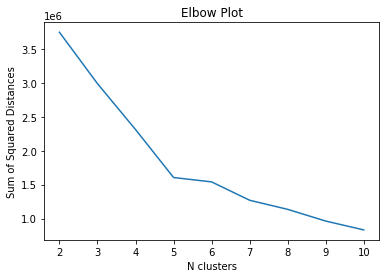

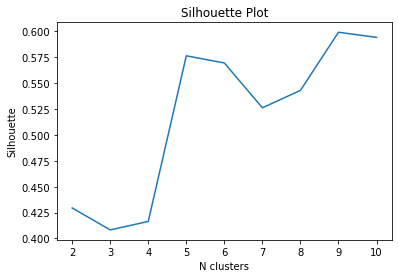

In [64]:
import matplotlib.pyplot as plt

# Elbow Method
plt.subplots(1, 1, sharex = 'row')
plt.plot(list(range(2, 11)), var)
plt.title('Elbow Plot')
plt.xlabel('N clusters')
plt.ylabel('Sum of Squared Distances')

# Silhouette
plt.subplots(1, 1, sharex = 'row')
plt.plot(list(range(2, 11)), sil)
plt.title('Silhouette Plot')
plt.xlabel('N clusters')
plt.ylabel('Silhouette')

plt.show()